In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from skimage.io import imread
%matplotlib inline

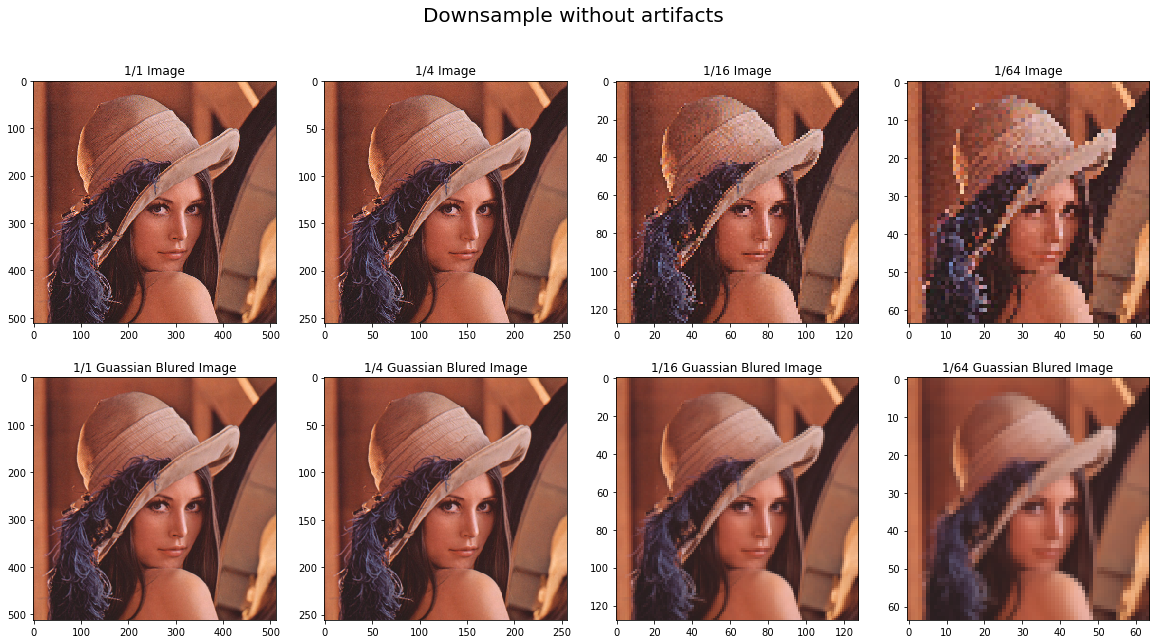

In [3]:
img=imread('./lena.png')
img2=img[::2,::2]
imgg=cv2.GaussianBlur(img,(3,3),-1)
img2g=imgg[::2,::2]
img4g=cv2.GaussianBlur(img2g,(3,3),-1)
img4g=img4g[::2,::2]
img4=img[::4,::4]
img8=img[::8,::8]
img8g=cv2.GaussianBlur(img4g,(3,3),-1)
img8g=img8g[::2,::2]
imgs=[img,img2,img4,img8,imgg,img2g,img4g,img8g]
titles=["1/%d Image"%(d*d) for d in [1,2,4,8]]
titlesg=["1/%d Guassian Blured Image"%(d*d) for d in [1,2,4,8]]
titles=titles+titlesg

plt.figure(figsize=(20,10))
plt.suptitle("Downsample without artifacts", fontsize=20)
for iid in range(0,8):
    plt.subplot(2,4,iid+1)
    plt.title(titles[iid])
    plt.imshow(imgs[iid])
    
plt.show()

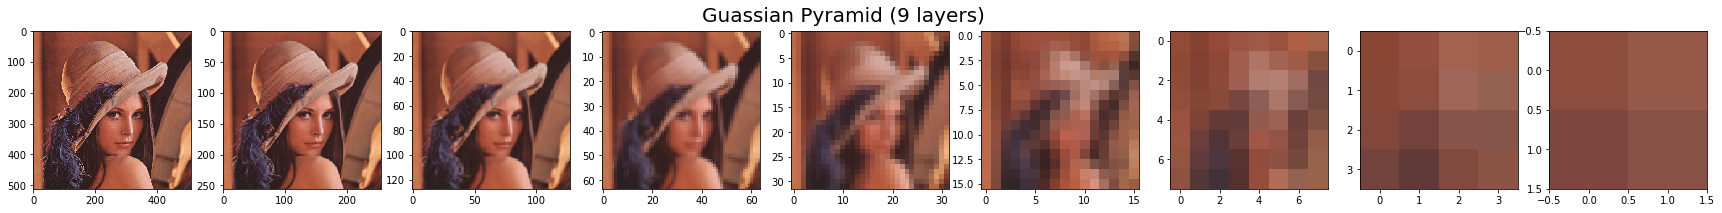

In [4]:
def createGaussianPyramid(img):
    pyramid=[img]
    newimg=img
    while True:
        imgcols=newimg.shape[0]
        imgrows=newimg.shape[1]
        newcols=(imgcols+1)//2
        newrows=(imgrows+1)//2
        if (newcols*2-imgcols)>2 or (newrows*2-imgrows)>2 or newcols<2 or newrows<2:
            break
        newimg=cv2.pyrDown(newimg)
        pyramid.append(newimg)
    return pyramid
    
pyramid=createGaussianPyramid(img)    

plt.figure(figsize=(30,3))
plt.suptitle("Guassian Pyramid (9 layers)", fontsize=20)
count=len(pyramid)
for i in range(count):
    plt.subplot(1, count, i+1)
    plt.imshow(pyramid[i])
plt.show()

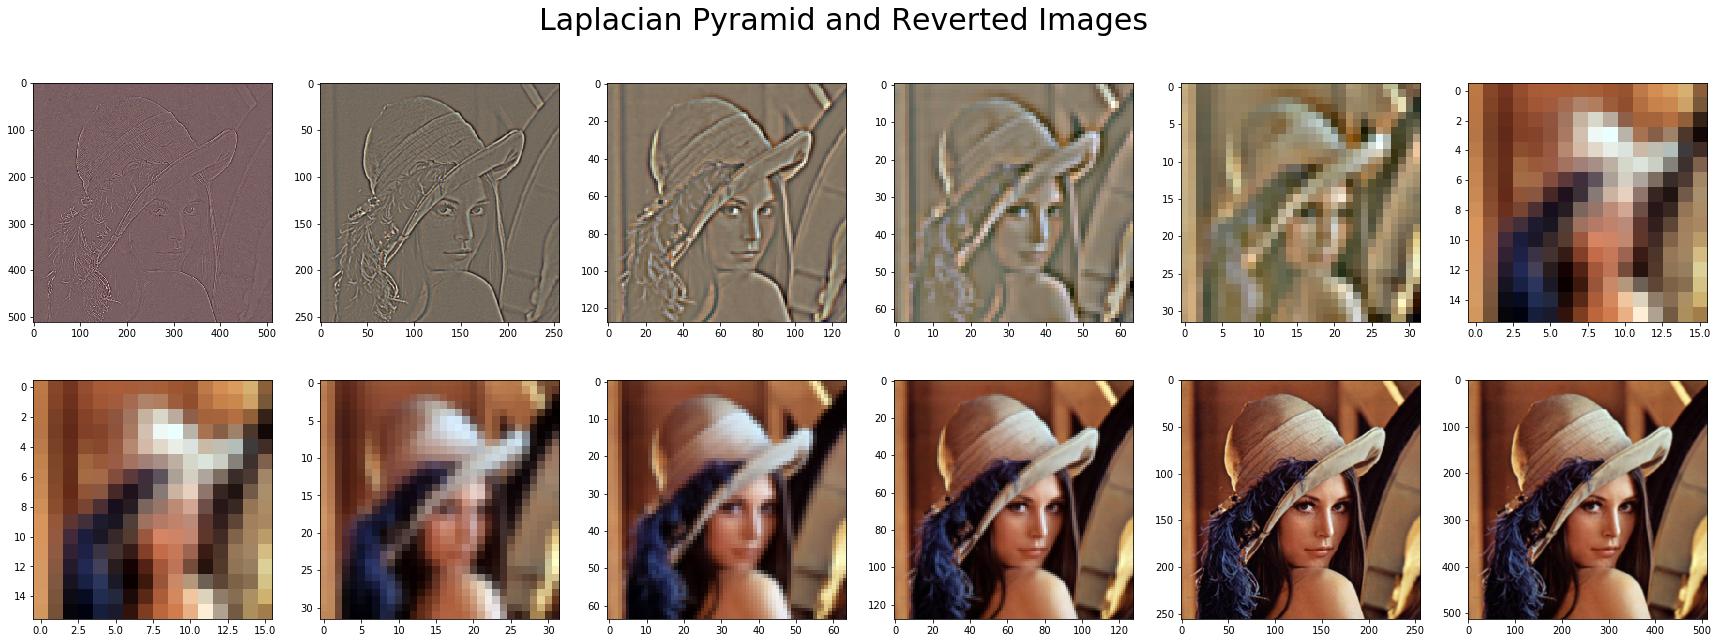

In [5]:
def normFloatArray(imgIn):
    """
    Normalize input float array value to between [0, 1]
    If the input image has multi-channels, it does the normalization
    channel by channel, independently.
    
    Parameters
    ----------
    imgIn: input image array

    Returns
    -------
    output image, value between [0, 1]
    """
    imgOut = imgIn.copy()
    if imgIn.max()==imgIn.min():
        imgOut = np.zeros(imgIn.shape)
    elif len(imgIn.shape)==2:        
        imgOut = (imgOut - imgOut.min())/(imgOut.max()-imgOut.min())
    elif len(imgIn.shape)==3:
        for c in range(3):
            imgOut[:,:,c] = (imgOut[:,:,c] - imgOut[:,:,c].min())/(imgOut[:,:,c].max()-imgOut[:,:,c].min())
    return imgOut

def createLaplacianPyramid(img):
    imgfloat=img.astype(np.float64)
    pyramid=[]
    newimg=imgfloat
    while True:
        imgcols=newimg.shape[0]
        imgrows=newimg.shape[1]
        newcols=(imgcols+1)//2
        newrows=(imgrows+1)//2
        if (newcols*2-imgcols)>2 or (newrows*2-imgrows)>2 or newcols<16 or newrows<16:
            pyramid.append(downSampledImg)
            break
        downSampledImg=cv2.pyrDown(newimg)        
        upSampledImg=cv2.pyrUp(downSampledImg)
        resImg=newimg-upSampledImg
        newimg=downSampledImg
        pyramid.append(resImg)
    return pyramid

def revertImgFromLaplacianPyramid(lapPyr):
    revertedImgs=[]
    count=len(lapPyr)
    baseImg=lapPyr[-1]
    revertedImgs.append(baseImg)
    baseImg=cv2.pyrUp(baseImg)
    for i in range(-2,-count,-1):
        baseImg+=lapPyr[i]
        revertedImgs.append(baseImg)
        baseImg=cv2.pyrUp(baseImg)
    revertedImgs.append(baseImg)
    return revertedImgs
    
pyramid=createLaplacianPyramid(img) 
revertedImgs=revertImgFromLaplacianPyramid(pyramid)

plt.figure(figsize=(30,10))
plt.suptitle("Laplacian Pyramid and Reverted Images", fontsize=30)
count=len(pyramid)
for i in range(count):
    plt.subplot(2, count, i+1)
    imgToShow=pyramid[i].copy()
    imgToShow=normFloatArray(imgToShow)
    plt.imshow(imgToShow)

    plt.subplot(2, count, i+1+count)
    imgToShow=revertedImgs[i].copy()
    imgToShow=normFloatArray(imgToShow)
    plt.imshow(imgToShow)
plt.show()

In [6]:
resErr=np.abs(img.astype(np.float64)-revertedImgs[-1])
print("Residual Error between original image and reverted Image: %.2f, the error ratio is: %.2f"%(resErr.sum(), resErr.sum()/img.sum()))

Residual Error between original image and reverted Image: 4188511.02, the error ratio is: 0.06


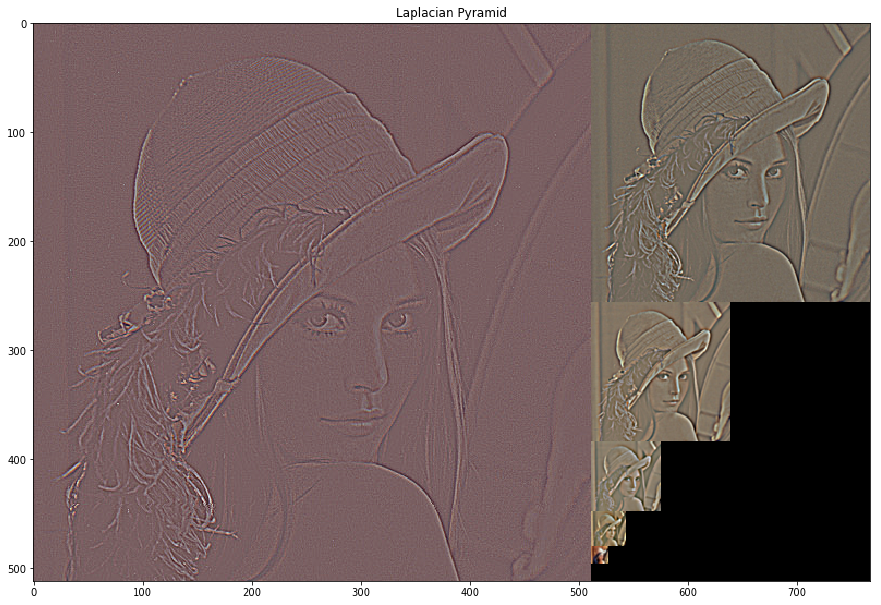

In [7]:
def testShowPyramid(image, maxLevel):
    rows, cols = image.shape[0:2]
    imgPyramid = createLaplacianPyramid(image)
    composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)
    composite_image[:rows, :cols, :] = normFloatArray(imgPyramid[0])
    i_row = 0
    for p in imgPyramid[1:]:
        n_rows, n_cols = p.shape[:2]
        composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = normFloatArray(p)
        i_row += n_rows

    plt.figure(figsize=(15,15))
    plt.title("Laplacian Pyramid")
    plt.imshow(composite_image)
    plt.show()
testShowPyramid(img,6)

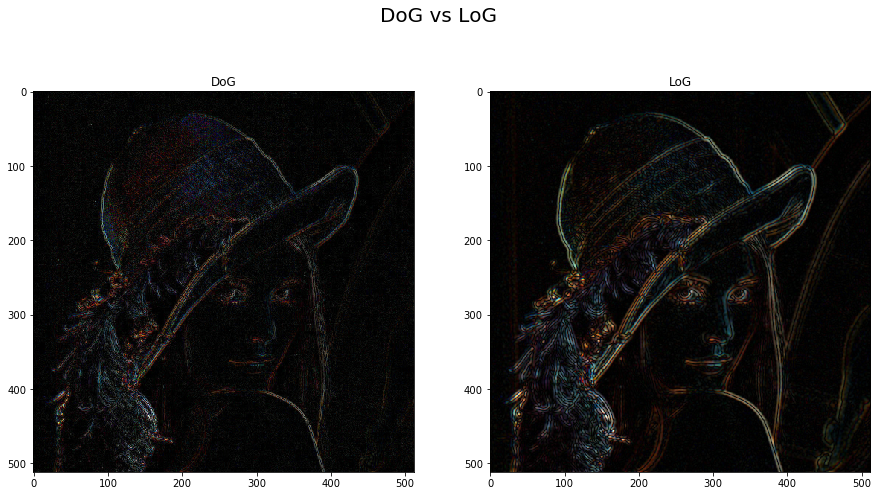

In [8]:
imgFloat=img.copy().astype(np.float64)
imgGBlured=cv2.GaussianBlur(imgFloat, (7,7),-1)
imgDoG=np.abs(imgGBlured-imgFloat)
imgLoG=np.abs(cv2.Laplacian(imgGBlured, -1, ksize=1))
plt.figure(figsize=(15,8))
plt.suptitle("DoG vs LoG", fontsize=20)
plt.subplot(1,2,1)
plt.imshow(normFloatArray(imgDoG))
plt.title("DoG")
plt.subplot(1,2,2)
plt.imshow(normFloatArray(imgLoG))
plt.title("LoG")
plt.show()